In [18]:
# Cell 1: Imports
import pandas as pd
import os
from PIL import Image
from pillow_heif import register_heif_opener
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
register_heif_opener()

In [19]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [21]:
# Cell 2: Dataset Class with corrected label and path handling
import os

class PlantImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {'h': 0, 'u': 1}

        # Optional: Map label column just once here to avoid repeating every __getitem__
        self.data = self.data[self.data['class'].isin(self.label_map)]
        self.data['encoded_label'] = self.data['class'].map(self.label_map).astype(int)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Make sure to use os.path.join for cross-platform compatibility
        path="RAW//imgs//"
        img_path = path+self.data.iloc[idx]['folder']+"//"+self.data.iloc[idx]['image_name']

        # Read label
        label = self.data.iloc[idx]['encoded_label']

        # Open and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

In [22]:
# Cell 3: Image transforms and data loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = PlantImageDataset(csv_file='aug_final_dataset.csv', transform=transform)

# Split into train/test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

In [23]:
# # Cell 4: MobileNetV2 (smallest version, modified for 2 classes)
# from torchvision.models import mobilenet_v2

# class MobileNetSmall(nn.Module):
#     def __init__(self):
#         super(MobileNetSmall, self).__init__()
#         self.model = mobilenet_v2(pretrained=False)  # Width multiplier reduces channels = fewer params
#         self.model.classifier[1] = nn.Linear(self.model.last_channel, 2)  # Modify output to 2 classes

#     def forward(self, x):
#         return self.model(x)

In [24]:
# Cell 5: VGG-Lite (Custom compact VGG-style network)
class VGGLite(nn.Module):
    def __init__(self):
        super(VGGLite, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [25]:
# Cell 6: train function

def train_model(model, train_loader, test_loader, num_epochs=10, lr=0.001):
    device = 'cuda'
    model = model.to(device)  # Make sure model runs in float32
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print("Unique label values in training set:", set([label for _, label in train_loader.dataset]))


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device).float()              # float32 for images
            labels = labels.to(device).long()               # long for labels

            optimizer.zero_grad()
            outputs = model(images).float()                 # Ensure model outputs are float32
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")
    
    return model


In [26]:
# Cell 7: Evaluation function
def evaluate_model(model, test_loader):
    device = 'cuda'
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Healthy', 'Unhealthy']))

In [35]:
import torch
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from io import StringIO

def evaluate_vgg_with_roc(model, test_loader, model_name="VGGLite", device='cuda',
                          save_full_csv=True, save_min_csv=True, return_csv_string=True):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]   # Probability for class 1 (Unhealthy)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    # 🧾 Classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=['Healthy (h)', 'Unhealthy (u)']))

    # 📊 Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Healthy', 'Unhealthy'],
                yticklabels=['Healthy', 'Unhealthy'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # 🧠 ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 📁 Save Predictions to CSV
    csv_vgg_model = None

    # Full CSV (detailed)
    if save_full_csv:
        df_full = pd.DataFrame({
            'True Label': ['Healthy' if x == 0 else 'Unhealthy' for x in y_true],
            'Predicted Label': ['Healthy' if x == 0 else 'Unhealthy' for x in y_pred],
            'Predicted Probability (Unhealthy)': y_probs
        })
        full_csv_filename = f"{model_name.lower()}_predictions.csv"
        df_full.to_csv(full_csv_filename, index=False)
        print(f"Saved detailed predictions to '{full_csv_filename}'")

    # Minimal CSV (h/u only)
    if save_min_csv or return_csv_string:
        map_hu = {0: 'h', 1: 'u'}
        df_min = pd.DataFrame({
            'True Label': [map_hu[int(x)] for x in y_true],
            'Predicted Label': [map_hu[int(x)] for x in y_pred]
        })

        if save_min_csv:
            min_csv_filename = f"{model_name.lower()}_preds_min.csv"
            df_min.to_csv(min_csv_filename, index=False)
            print(f"Saved minimal predictions to '{min_csv_filename}'")

        if return_csv_string:
            buf = StringIO()
            df_min.to_csv(buf, index=False)
            csv_vgg_model = buf.getvalue()
            print("\ncsv_vgg_model string preview:")
            print(csv_vgg_model.strip())

    return {
        "accuracy": acc,
        "auc": auc_score,
        "csv_vgg_model": csv_vgg_model
    }

# Example usage:
# results = evaluate_vgg_with_roc(vgg_model, test_loader, model_name="VGGLite")
# print(results["csv_vgg_model"])


In [28]:
# # Cell 8: Run training and evaluation for LeNet
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# print("Training squeezenet_small...")
# lenet_model = VGGLite()
# trained_lenet = train_model(lenet_model, train_loader, test_loader)
# evaluate_vgg_with_roc(trained_lenet, test_loader)

In [29]:
# trained_lenet = train_model(lenet_model, train_loader, test_loader)
# evaluate_vgg_with_roc(trained_lenet, test_loader)

In [30]:
# Cell 9: Run training and evaluation for AlexNet
print("Training VGGLite...")
alexnet_model = VGGLite()

Training VGGLite...


In [31]:
trained_alexnet = train_model(alexnet_model, train_loader, test_loader) 

Unique label values in training set: {np.int64(0), np.int64(1)}
Epoch 1/10, Loss: 1.0663
Epoch 2/10, Loss: 0.6939
Epoch 3/10, Loss: 0.6834
Epoch 4/10, Loss: 0.5476
Epoch 5/10, Loss: 0.4469
Epoch 6/10, Loss: 0.3553
Epoch 7/10, Loss: 0.3048
Epoch 8/10, Loss: 0.2311
Epoch 9/10, Loss: 0.1938
Epoch 10/10, Loss: 0.1428



Classification Report for VGGLite:
               precision    recall  f1-score   support

  Healthy (h)       0.81      0.97      0.88        30
Unhealthy (u)       0.97      0.82      0.89        40

     accuracy                           0.89        70
    macro avg       0.89      0.90      0.89        70
 weighted avg       0.90      0.89      0.89        70

Accuracy: 0.8857


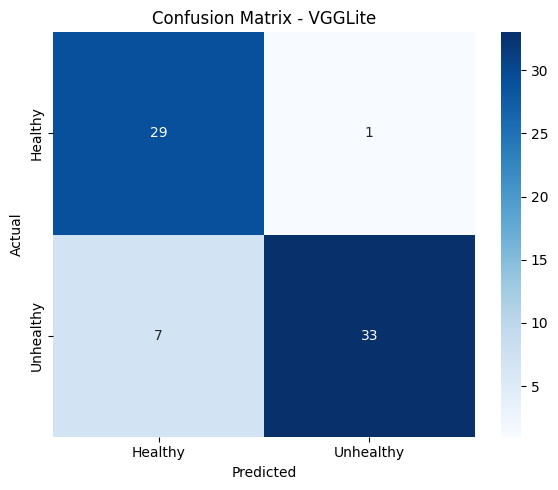

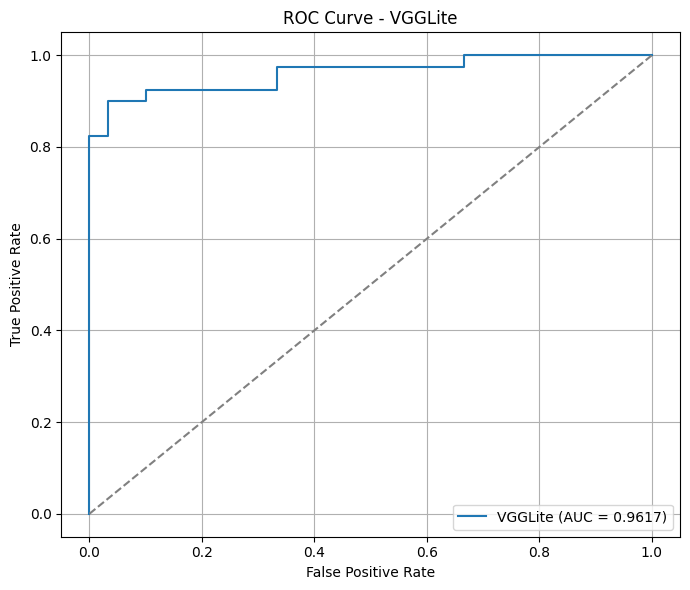

Saved detailed predictions to 'vgglite_predictions.csv'
Saved minimal predictions to 'vgglite_preds_min.csv'

csv_vgg_model string preview:
True Label,Predicted Label
u,u
u,u
u,u
u,u
u,u
h,h
u,h
u,u
u,u
h,h
u,h
h,h
h,h
u,u
u,u
h,h
u,h
u,u
u,u
h,h
u,u
u,u
u,u
u,u
u,u
h,h
h,h
h,h
h,h
h,h
h,h
h,h
u,u
u,h
u,u
h,h
u,u
h,u
h,h
h,h
u,h
u,u
u,u
u,u
u,u
h,h
h,h
h,h
u,u
h,h
u,u
h,h
u,u
u,u
u,u
u,u
h,h
h,h
u,u
u,u
u,h
u,h
u,u
h,h
h,h
h,h
h,h
h,h
h,h
u,u


{'accuracy': 0.8857142857142857,
 'auc': 0.9616666666666667,
 'csv_vgg_model': 'True Label,Predicted Label\r\nu,u\r\nu,u\r\nu,u\r\nu,u\r\nu,u\r\nh,h\r\nu,h\r\nu,u\r\nu,u\r\nh,h\r\nu,h\r\nh,h\r\nh,h\r\nu,u\r\nu,u\r\nh,h\r\nu,h\r\nu,u\r\nu,u\r\nh,h\r\nu,u\r\nu,u\r\nu,u\r\nu,u\r\nu,u\r\nh,h\r\nh,h\r\nh,h\r\nh,h\r\nh,h\r\nh,h\r\nh,h\r\nu,u\r\nu,h\r\nu,u\r\nh,h\r\nu,u\r\nh,u\r\nh,h\r\nh,h\r\nu,h\r\nu,u\r\nu,u\r\nu,u\r\nu,u\r\nh,h\r\nh,h\r\nh,h\r\nu,u\r\nh,h\r\nu,u\r\nh,h\r\nu,u\r\nu,u\r\nu,u\r\nu,u\r\nh,h\r\nh,h\r\nu,u\r\nu,u\r\nu,h\r\nu,h\r\nu,u\r\nh,h\r\nh,h\r\nh,h\r\nh,h\r\nh,h\r\nh,h\r\nu,u\r\n'}

In [36]:
evaluate_vgg_with_roc(trained_alexnet, test_loader)

NameError: name 'model' is not defined